In [115]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3
import scoobi.scoobi as scoobi

import lina

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()

def restart_clients():
    client0 = INDIClient('localhost', 7624)
    client0.start()

    client = IndiClient()
    client.connect()
    client.get_properties()

In [6]:
scoobi.home_block(client0)

In [8]:
scoobi.move_block_out(client0)

In [116]:
reload(scoobi)
xc, yc = (4263, 2920)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [117]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', dm_channel='dm00disp05')

# Do the normalization

In [13]:
scoobi.move_psf(-50, 0, client0)

In [118]:
reload(scoobi)
I.set_zwo_exp_time(120e-6, client0)

Set the ZWO exposure time to 1.20e-04s


In [119]:
reload(scoobi)
I.set_zwo_gain(250, client0)

Set the ZWO gain setting to 250.0


In [121]:
reload(scoobi)
I.set_fib_atten(28, client)

Set the fiber attenuation to 28.0


INFO:utils:Got semaphore index 1.


44017.32


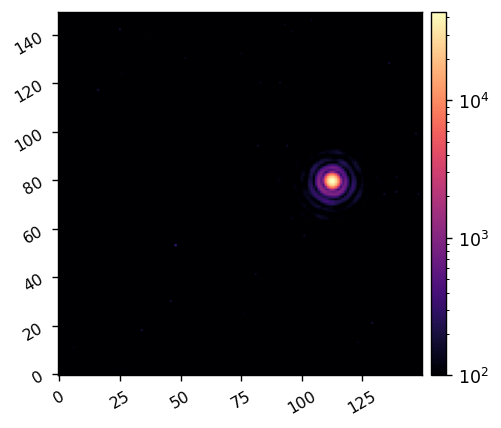

In [122]:
I.Nframes = 100
ref_psf = I.snap()
print(xp.max(ref_psf))
imshow1(ref_psf, lognorm=True, vmin=1e2)

In [123]:
I.Imax_ref = copy.copy(xp.max(ref_psf))
I.texp_ref = 120e-6
I.att_ref = 28
I.gain_ref = 250
print(I.Imax_ref, I.texp_ref, I.att_ref, I.gain_ref  )

44017.32 0.00012 28 250


In [124]:
I.reset_dm()

In [138]:
scoobi.move_psf(-2, 0, client0)

In [137]:
scoobi.move_psf(0, -5, client0)

In [133]:
I.set_fib_atten(0, client)

Set the fiber attenuation to 0.0


In [206]:
I.set_zwo_exp_time(0.0005, client0)

Set the ZWO exposure time to 5.00e-04s


In [61]:
I.set_zwo_gain(250, client0)

Set the ZWO gain setting to 250.0


In [141]:
reload(scoobi)
scoobi.move_block_in(client0)

In [143]:
reload(scoobi)
scoobi.move_block_out(client0)

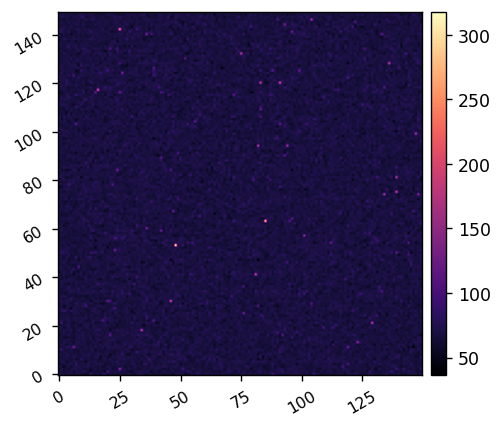

In [142]:
I.Nframes = 100
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()
imshow1(dark_frame)

I.df = copy.copy(dark_frame)

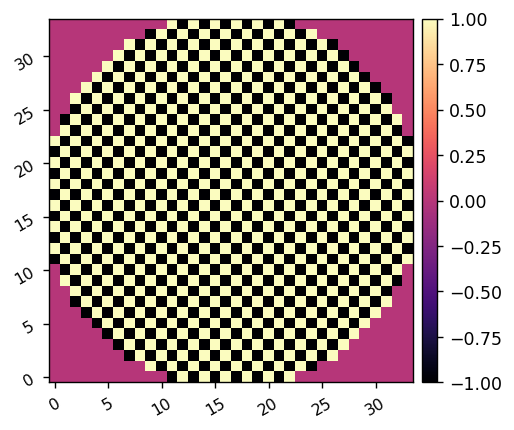

In [144]:
reload(scoobi.utils)
waffle_command = scoobi.utils.create_fourier_command(x_cpa=17, y_cpa=17) * xp.array(I.dm_mask)
imshow1(waffle_command)

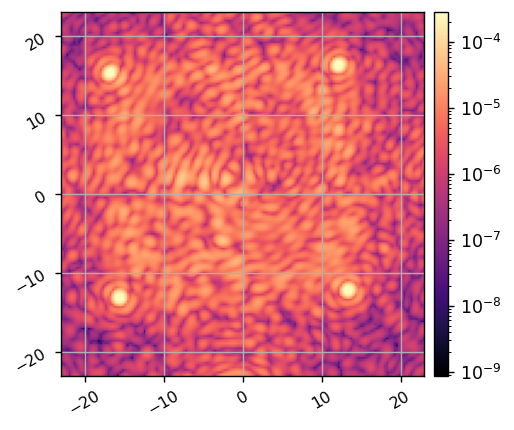

In [145]:
I.set_dm(15e-9 * waffle_command)
I.x_shift = 0
I.y_shift = 0

I.subtract_dark = True
I.return_ni = True
waffle_im = I.snap()
imshow1(waffle_im, lognorm=True, pxscl=I.psf_pixelscale_lamD, grid=True)

Centroids:
 [[ 23.59065435  31.86656239]
 [ 19.75821651 124.49613863]
 [113.95357302 127.60154147]
 [117.92472229  34.96250803]
 [ 23.59065435  31.86656239]]


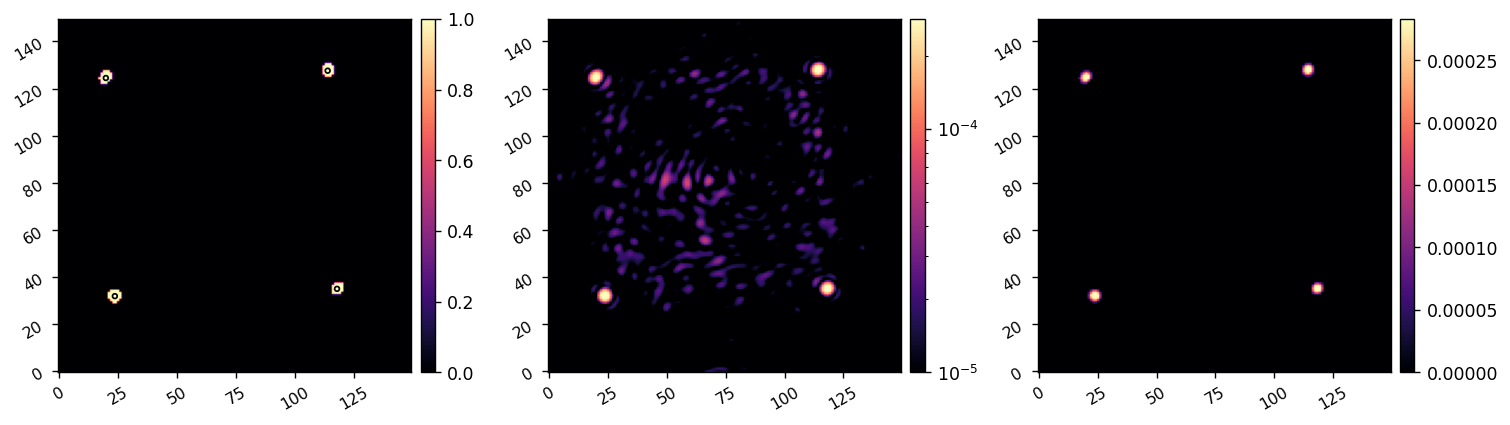

Angle:  87.85206956400025
Measured center in X:  68.80180054172352
Measured center in Y:  79.7655036655731
Required shift in X:  6.0
Required shift in Y:  -5.0


In [147]:
reload(scoobi.utils)

xshift,yshift,angle = scoobi.utils.measure_center_and_angle(waffle_im, I.psf_pixelscale_lamD, im_thresh=5e-5, r_thresh=15)

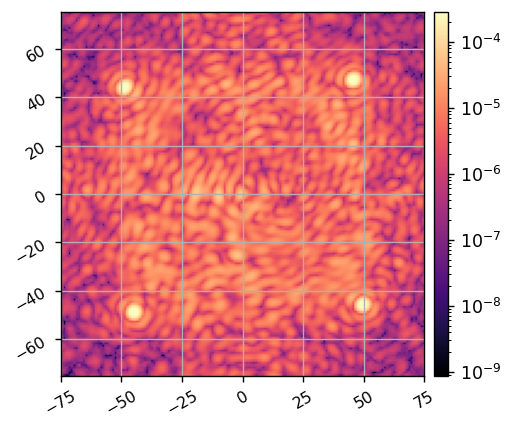

In [148]:
I.Nframes = 10
I.npsf = 150
I.x_shift = xshift
I.y_shift = yshift -1

I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()
imshow1(coro_im, lognorm=True, pxscl=1, grid=True)

In [149]:
I.zero_dm()

# Choose modes and probes for iEFC

In [213]:
reload(lina.utils)

iwa = 2.5
owa = 12
rotation = 0
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, iwa, owa, edge=iwa, rotation=rotation)

6.1398589803956865e-06


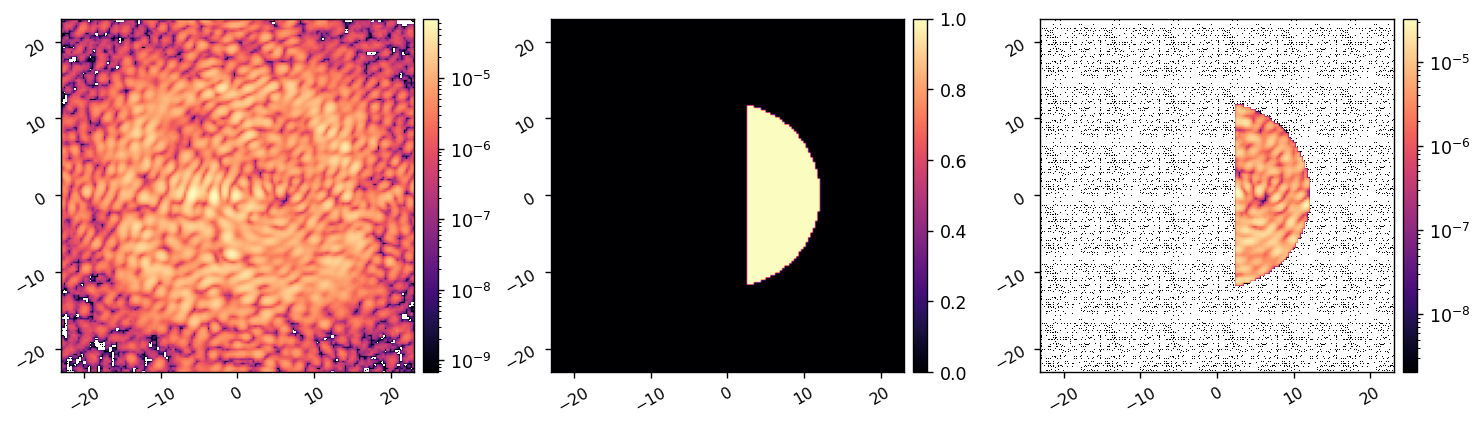

Saved data to:  ../data/20240822_ref_coro_im.fits


In [214]:
I.zero_dm()
I.Nframes = 10
I.subtract_dark = True
I.return_ni = True

ref_coro_im = I.snap()
print(xp.mean(ref_coro_im[control_mask]))
imshow3(ref_coro_im, control_mask, control_mask * ref_coro_im,
        lognorm1=True, lognorm3=True, pxscl=I.psf_pixelscale_lamD)
lina.utils.save_fits(f'../data/{today}_ref_coro_im.fits', ref_coro_im)

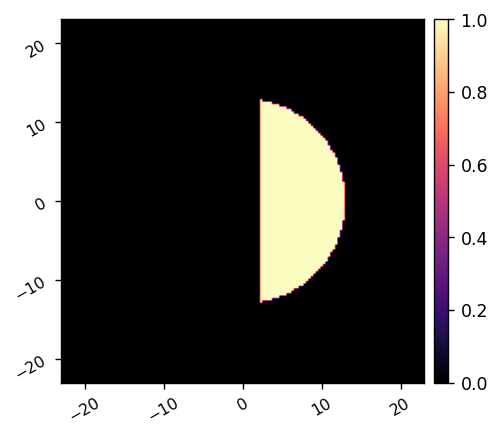

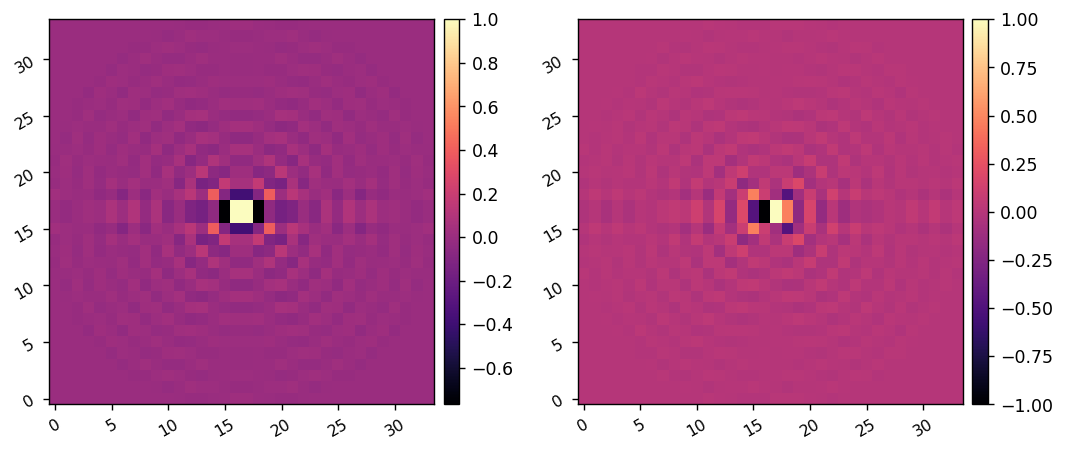

In [216]:
probe_iwa = 2
probe_owa = 13
probe_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, probe_iwa, probe_owa, edge=probe_iwa)
imshow1(probe_mask, pxscl=I.psf_pixelscale_lamD)
probe_modes = lina.utils.create_fourier_probes(I, probe_mask, fourier_sampling=0.25, 
                                             #   shift=[(0,8), (0,-8)], 
                                            #    shift=[(-5,6), (5,6), (0, -5)], 
                                               use_weighting=True,
                                               nprobes=2, 
                                               )
# for i in range(probe_modes.shape[0]):
#     probe_modes[i] = xp.rot90(probe_modes[i])
imshow2(probe_modes[0], probe_modes[1])
# imshow3(probe_modes[0], probe_modes[1], probe_modes[2])

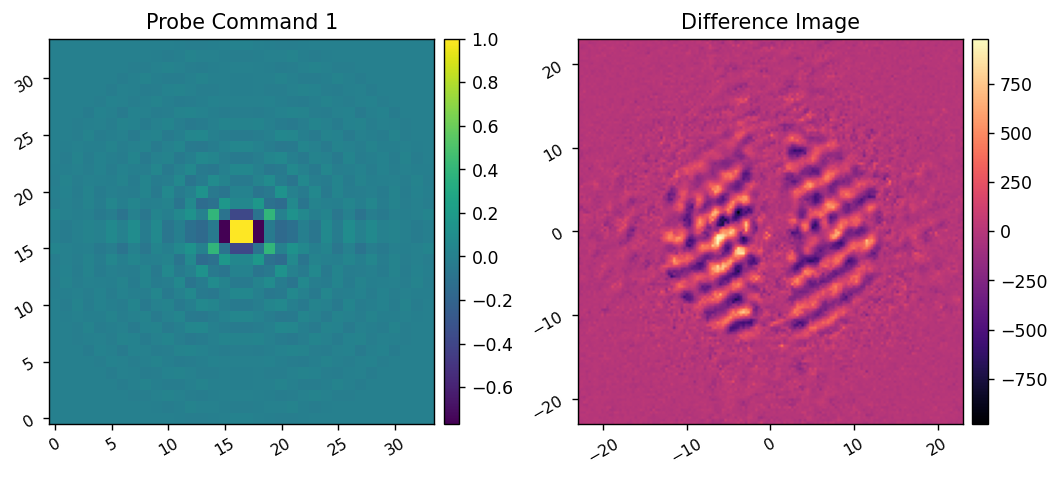

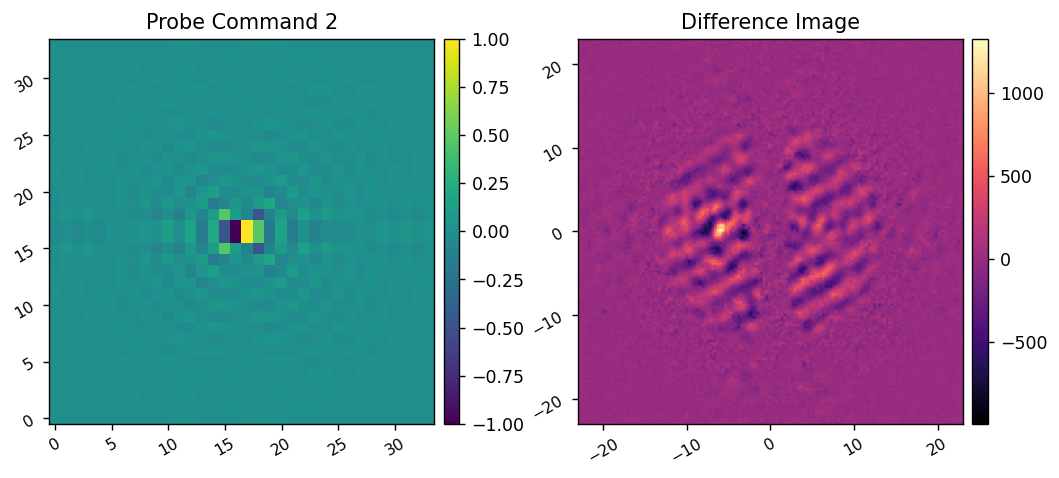

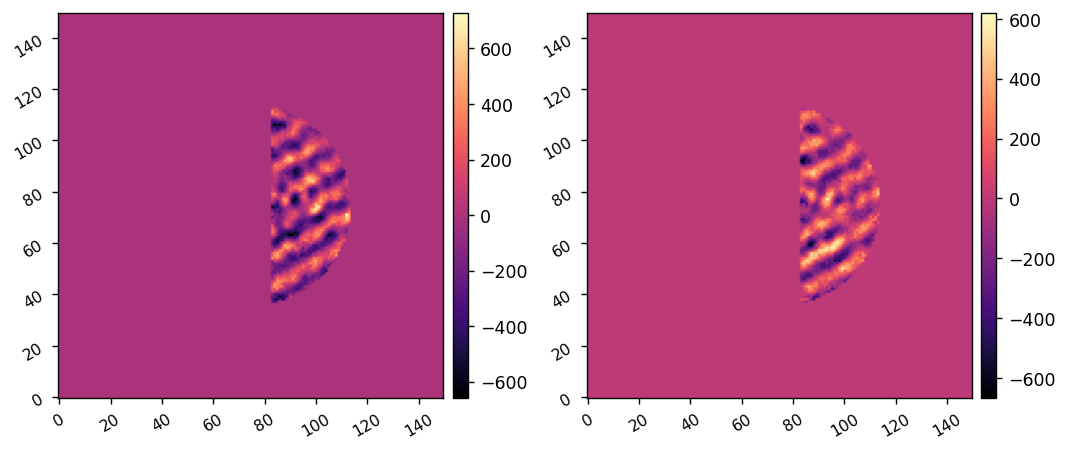

In [217]:
reload(lina.iefc)

I.Nframes = 10
I.subtract_dark = False
I.return_ni = True
diff_ims = lina.iefc.take_measurement(I, probe_modes, 5e-9, plot=True)
diff_ims *= control_mask
imshow2(diff_ims[0], diff_ims[1])
# imshow3(diff_ims[0], diff_ims[1], diff_ims[2])

444

222

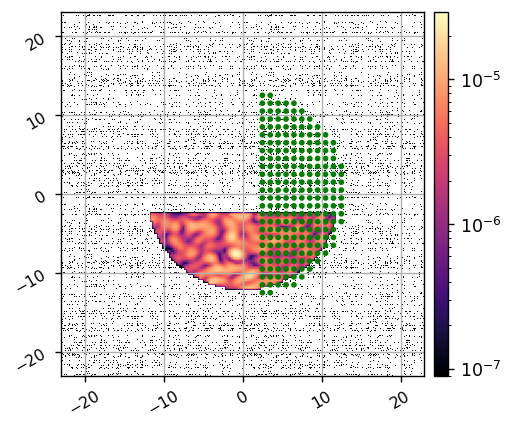

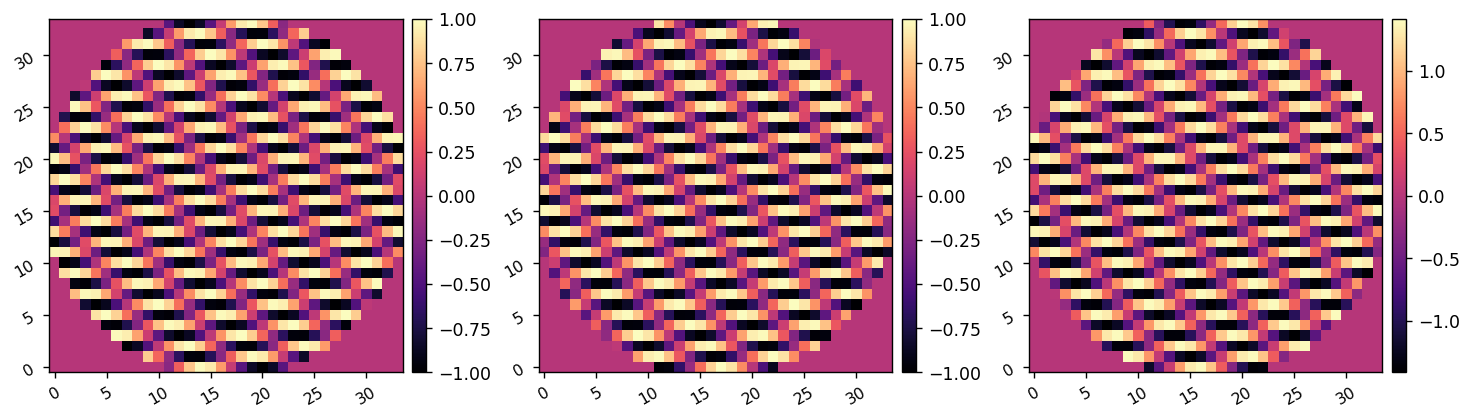

In [58]:
reload(lina.utils)

calib_iwa = 2
calib_owa = 13
calib_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, calib_iwa, calib_owa, edge=calib_iwa, rotation=0)
calib_modes, fs = lina.utils.create_fourier_modes(I, calib_mask, fourier_sampling=1, return_fs=True) 
calib_modes = xp.array(calib_modes)
nmodes = calib_modes.shape[0]
nf = nmodes//2
display(nmodes, nf)

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.25
    patches.append(Circle(center, radius, fill=True, color='g'))
    
imshow1(ref_coro_im*control_mask, lognorm=True, pxscl=I.psf_pixelscale_lamD, patches=patches, grid=True)
cos = calib_modes[0].reshape(I.Nact,I.Nact)
sin = calib_modes[0+nf].reshape(I.Nact,I.Nact)
imshow3(cos, sin, cos+sin)


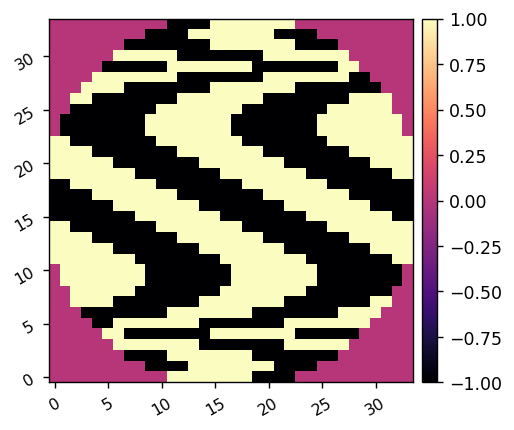

In [218]:
reload(lina.utils)
calib_modes = lina.utils.create_hadamard_modes(xp.array(I.dm_mask))
imshow1(calib_modes[8].reshape(I.Nact, I.Nact))


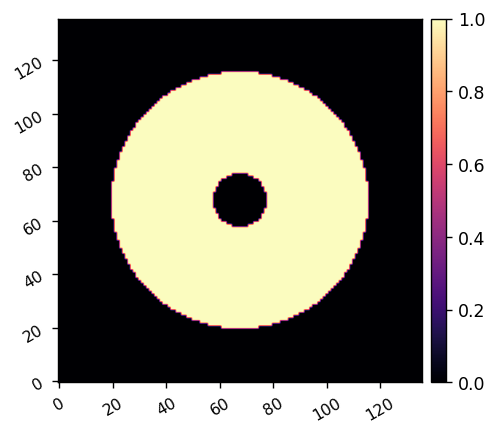

(1024,)
[1.2421408  2.21050163 1.63962848 1.73191144]


In [227]:
reload(scoobi.utils)
oversamp = 4

had_modes = xp.array(calib_modes)
ft_modes = []
for i in range(calib_modes.shape[0]//2):
    had_mode = had_modes[i,:I.Nact**2].reshape(I.Nact, I.Nact)
    ft_modes.append(xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(scoobi.utils.pad_or_crop(had_mode, I.Nact*oversamp)))))
mode_freqs = xp.abs(xp.array(ft_modes))

mode_freq_mask_pxscl = 1/oversamp
x = (xp.linspace(-I.Nact*oversamp//2, I.Nact*oversamp//2-1, I.Nact*oversamp) + 1/2)*mode_freq_mask_pxscl
x,y = xp.meshgrid(x,x)
r = xp.sqrt(x**2+y**2)
mode_freq_mask = (r>2.5)*(r<12)
imshow1(mode_freq_mask)

sum_vals = []
max_vals = []
for i in range(calib_modes.shape[0]//2):
    sum_vals.append(xp.sum(mode_freqs[i, mode_freq_mask]))
    max_vals.append(xp.max(mode_freqs[i, mode_freq_mask]**2))

biggest_sum = xp.max(xp.array(sum_vals))
biggest_max = xp.max(xp.array(max_vals))

scale_factors = []
for i in range(calib_modes.shape[0]//2):
    scale_factors.append((biggest_max/max_vals[i])**(1/5))
    # scale_factors.append((biggest_sum/sum_vals[i])**(1/2))
scale_factors = ensure_np_array(xp.array(scale_factors))
# scale_factors[scale_factors>2] = 2
# scale_factors[scale_factors<1/2] = 1/2

scale_factors = np.concatenate([scale_factors,scale_factors])
print(scale_factors.shape)

scale_thresh = 5
scale_factors[scale_factors>scale_thresh] = scale_thresh
print(scale_factors[8:12])

In [226]:
1.25 **(1/3)

1.077217345015942

In [202]:
I.zero_dm()

0.001
Calibrating iEFC...
	Calibrated mode 1024/1024 in 325.153s
Calibration complete.


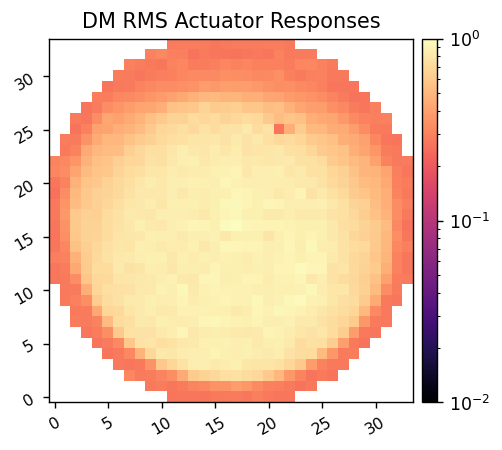

In [229]:
reload(lina.iefc)
I.zero_dm()

probe_amp = 5e-9
calib_amp = 2e-9

I.Nframes = 5
I.return_ni = True
I.subtract_dark = False
I.dm_delay = I.texp * 2
print(I.dm_delay)

time.sleep(2)
response_matrix, response_cube = lina.iefc.calibrate(I, control_mask, 
                                                     probe_amp, probe_modes, 
                                                     calib_amp, calib_modes, scale_factors=scale_factors, 
                                                    #  calib_amp, calib_modes[100:110], 
                                                    #  scale_factors=scale_factors[100:110], 
                                                    #  calib_amp, calib_modes[8:12], 
                                                    #  scale_factors=scale_factors[8:12], 
                                                     return_all=True,
                                                     )

In [274]:
lina.utils.save_fits(f'../data/{today}_iefc_hadamard_jac.fits', response_matrix)
lina.utils.save_fits(f'../data/{today}_iefc_hadamard_jac_cube.fits', response_cube)
lina.utils.save_fits(f'../data/{today}_iefc_probes.fits', probe_modes)

# lina.utils.save_fits('../data/iefc_fourier_jac_20240806.fits', response_matrix)
# lina.utils.save_fits('../data/iefc_fourier_jac_cube_20240806.fits', response_cube)

Saved data to:  ../data/20240822_iefc_hadamard_jac.fits
Saved data to:  ../data/20240822_iefc_hadamard_jac_cube.fits
Saved data to:  ../data/20240822_iefc_probes.fits


In [230]:
I.zero_dm()
all_ims = []
all_commands = []

In [79]:
I.set_dm(all_commands[-1])

0.1
Running iEFC...
	Closed-loop iteration 31 / 33


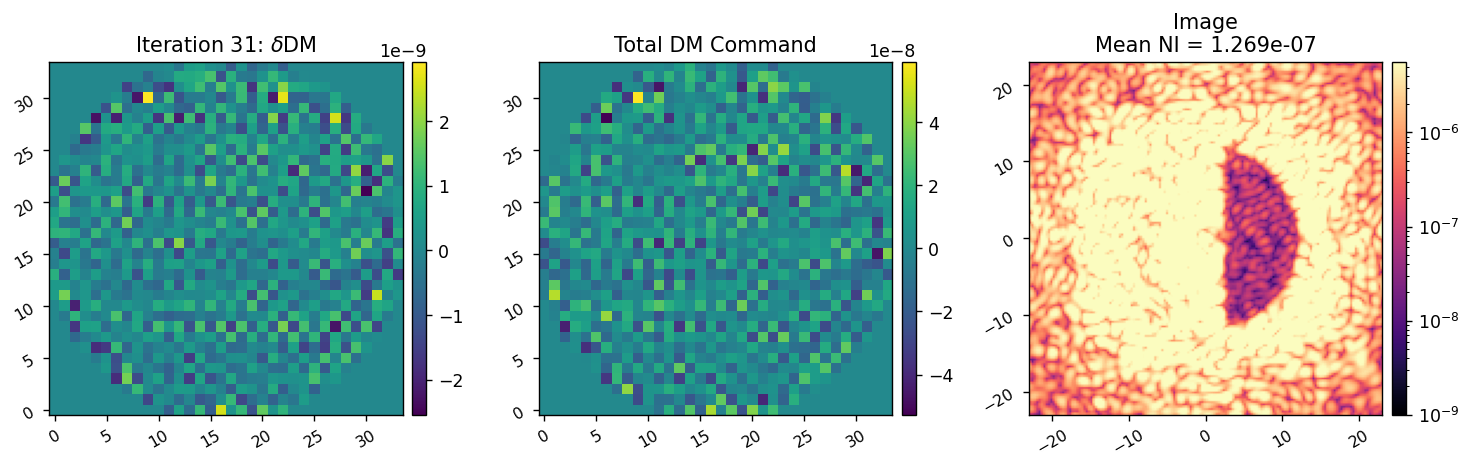

	Closed-loop iteration 32 / 33


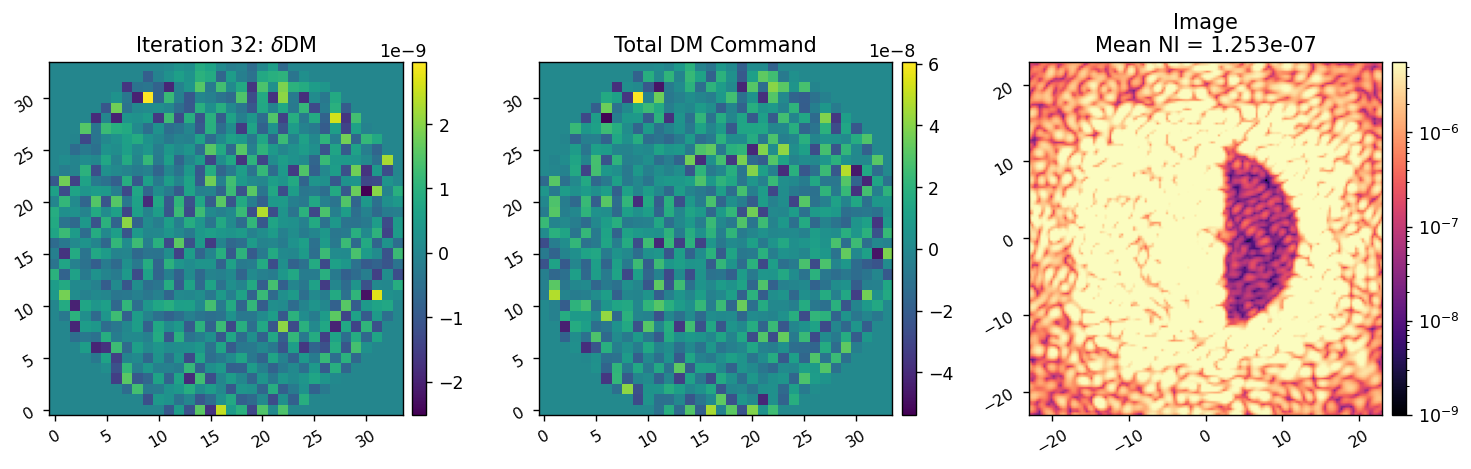

	Closed-loop iteration 33 / 33


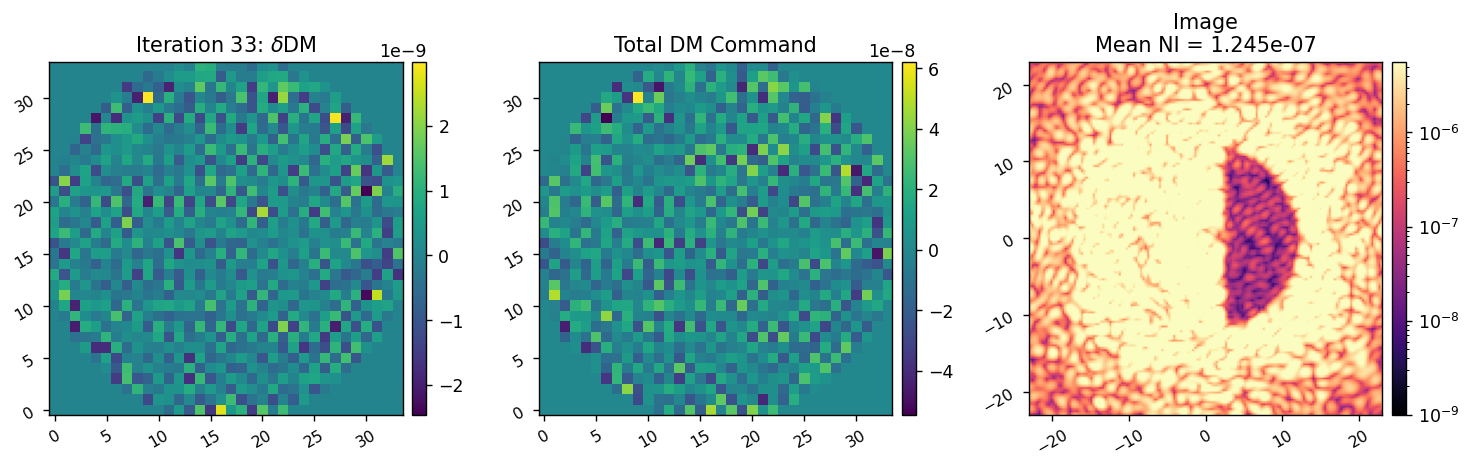

Closed loop for given control matrix completed in 12.959s.


In [252]:
reload(lina.utils)
reload(lina.iefc)

cm = lina.utils.beta_reg(response_matrix, -2.5)
cm = lina.utils.beta_reg(response_matrix, -3.5)
# cm = lina.utils.beta_reg(response_matrix, -5)

probe_amp = 5e-9
probe_amp = 4e-9
probe_amp = 3e-9
probe_amp = 2.5e-9
probe_amp = 2e-9
probe_amp = 1.5e-9

I.Nframes = 10
I.return_ni = True
I.dm_delay = 2*I.texp
print(I.dm_delay)

all_ims, all_commands = lina.iefc.run(I,
                                        cm,
                                        probe_modes, probe_amp, 
                                        calib_modes,
                                        control_mask,
                                        num_iterations=3,
                                        loop_gain=0.5, 
                                        leakage=0.0,
                                        plot_current=True,
                                        plot_all=True,
                                        plot_probes=False,
                                        plot_radial_contrast=False,
                                        all_ims=all_ims,
                                        all_commands=all_commands,
                                        )

In [245]:
I.set_zwo_exp_time(0.05, client0, delay=1)
I.set_zwo_gain(250, client0)
I.Nframes = 10

Set the ZWO exposure time to 5.00e-02s
Set the ZWO gain setting to 250.0


In [246]:
reload(scoobi)
scoobi.move_block_in(client0)

In [248]:
reload(scoobi)
scoobi.move_block_out(client0)

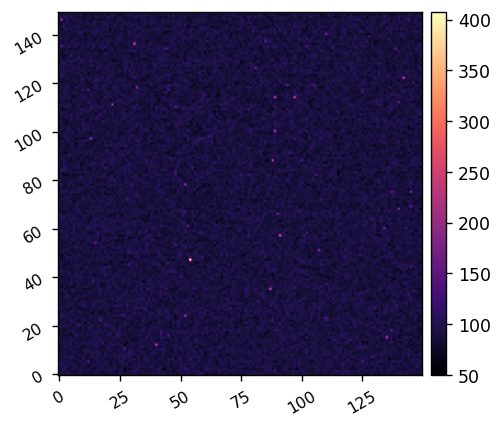

In [247]:
I.Nframes = 25
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()
imshow1(dark_frame)

I.df = copy.copy(dark_frame)

1.2306240373290672e-07


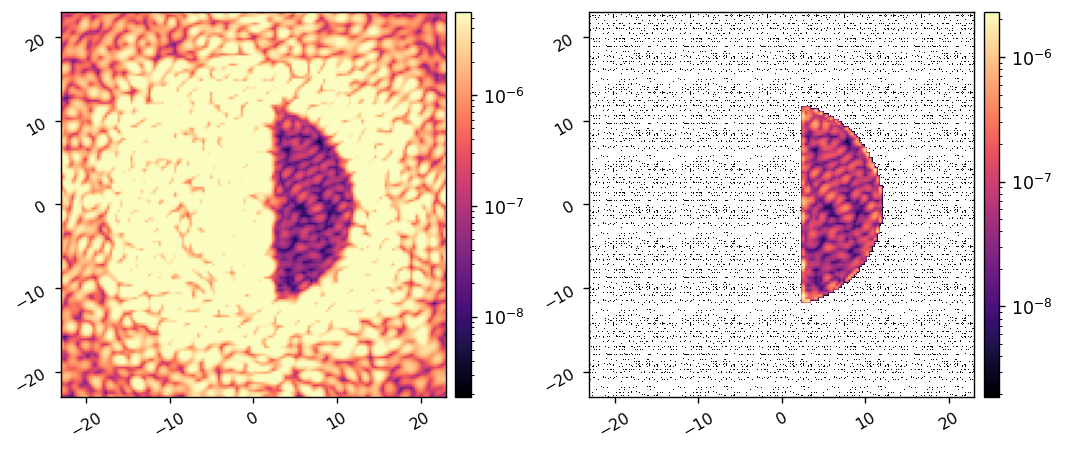

In [253]:
I.Nframes = 10
I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()

print(xp.mean(coro_im[control_mask]))
imshow2(coro_im, control_mask * coro_im,
        lognorm=True, pxscl=I.psf_pixelscale_lamD)

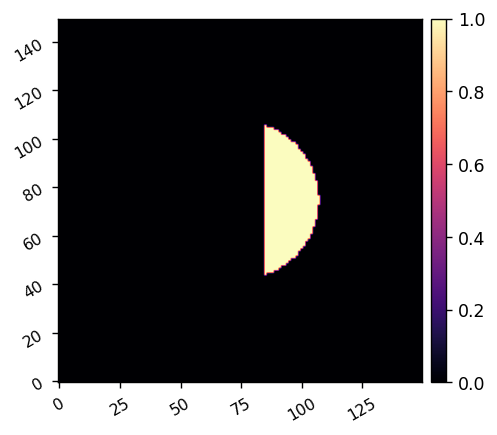

In [254]:
new_iwa = 3
new_owa = 10
new_control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, new_iwa, new_owa, edge=new_iwa, rotation=rotation)
imshow1(new_control_mask)

In [255]:
new_response_matrix = response_cube[:, :, new_control_mask.ravel()].reshape(1024, -1).T
new_response_matrix.shape

(2044, 1024)

0.2
Running iEFC...
	Closed-loop iteration 67 / 69


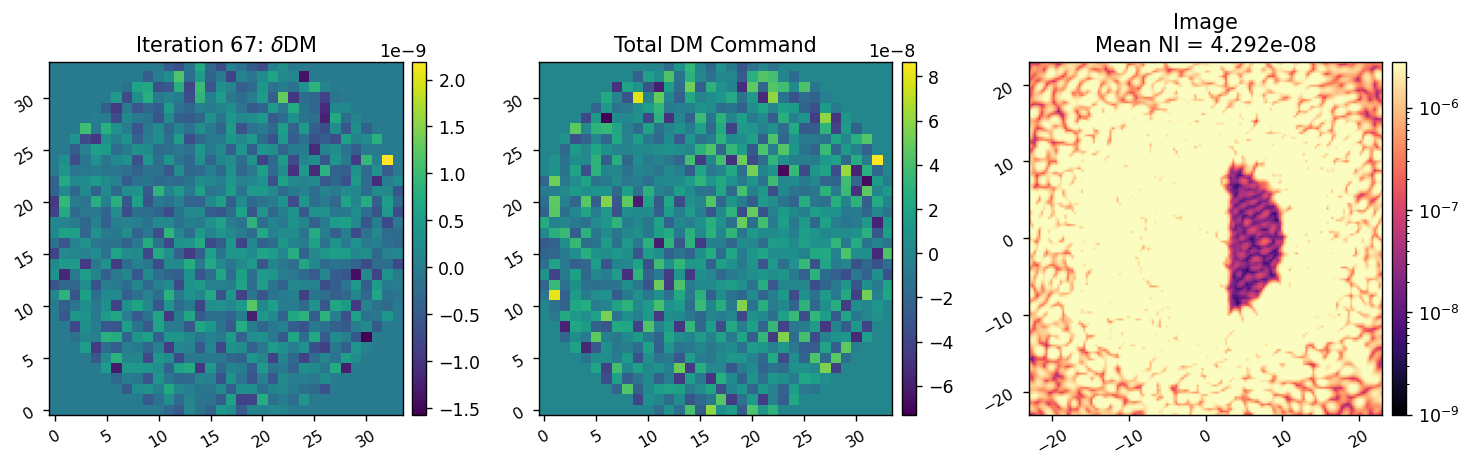

	Closed-loop iteration 68 / 69


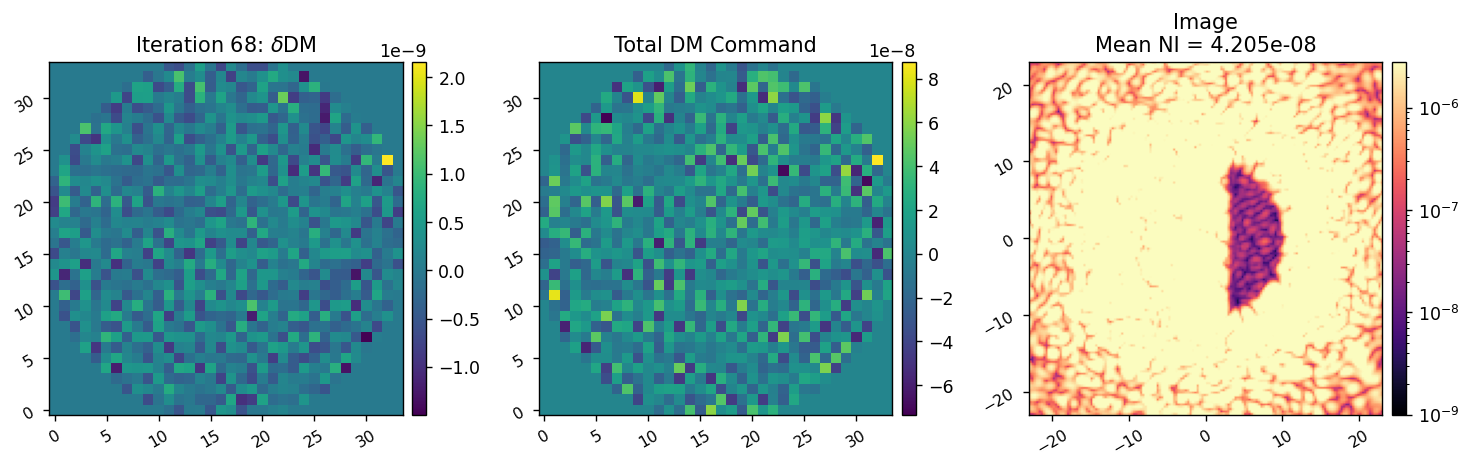

	Closed-loop iteration 69 / 69


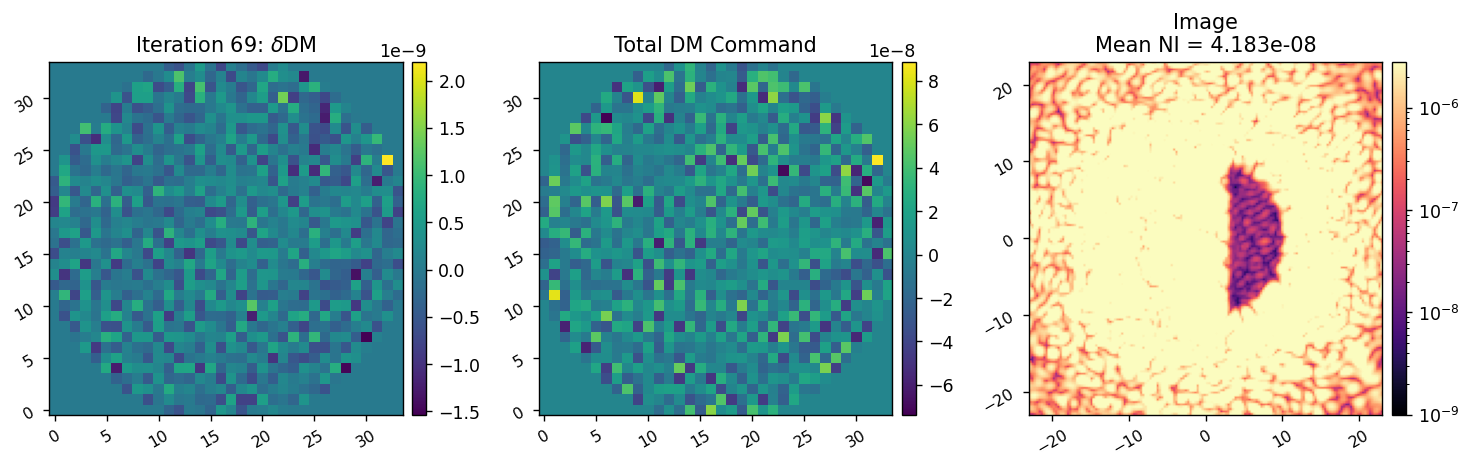

Closed loop for given control matrix completed in 23.109s.


In [273]:
reload(lina.utils)
reload(lina.iefc)

cm = lina.utils.beta_reg(new_response_matrix, -2.5)
# cm = lina.utils.beta_reg(new_response_matrix, -3.5)
# cm = lina.utils.beta_reg(new_response_matrix, -5)

probe_amp = 5e-9
# probe_amp = 4e-9
probe_amp = 2.5e-9
# probe_amp = 2e-9
probe_amp = 1.5e-9
# probe_amp = 1e-9
# probe_amp = 0.5e-9

I.Nframes = 10
I.return_ni = True
I.dm_delay = 2*I.texp
print(I.dm_delay)

all_ims, all_commands = lina.iefc.run(I,
                                        cm,
                                        probe_modes, probe_amp, 
                                        calib_modes,
                                        new_control_mask,
                                        num_iterations=3,
                                        loop_gain=0.5, 
                                        leakage=0.0,
                                        plot_current=True,
                                        plot_all=True,
                                        plot_probes=False,
                                        plot_radial_contrast=False,
                                        all_ims=all_ims, 
                                        all_commands=all_commands,
                                        )

In [275]:
lina.utils.save_fits(f'../data/{today}_iefc_hadamard_ims.fits', xp.array(all_ims))
lina.utils.save_fits(f'../data/{today}_iefc_hadamard_commands.fits', xp.array(all_commands))
lina.utils.save_fits(f'../data/{today}_iefc_control_mask_1.fits', control_mask.astype(int))
lina.utils.save_fits(f'../data/{today}_iefc_control_mask_2.fits', new_control_mask.astype(int))


Saved data to:  ../data/20240822_iefc_hadamard_ims.fits
Saved data to:  ../data/20240822_iefc_hadamard_commands.fits
Saved data to:  ../data/20240822_iefc_control_mask_1.fits
Saved data to:  ../data/20240822_iefc_control_mask_2.fits


In [264]:
I.set_zwo_exp_time(0.1, client0, delay=1)
I.set_zwo_gain(250, client0)
I.Nframes = 5

Set the ZWO exposure time to 1.00e-01s
Set the ZWO gain setting to 250.0


In [265]:
reload(scoobi)
scoobi.move_block_in(client0)

In [267]:
reload(scoobi)
scoobi.move_block_out(client0)

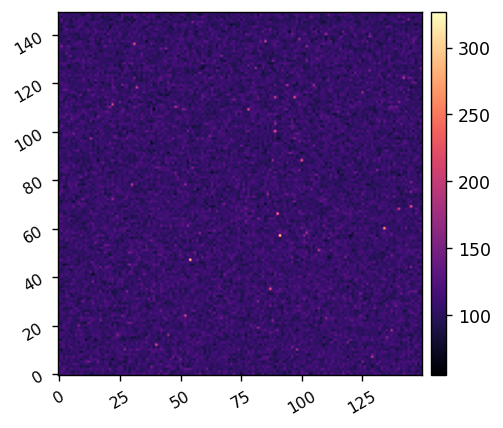

In [266]:
I.Nframes = 25
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()
imshow1(dark_frame)

I.df = copy.copy(dark_frame)

4.7150037036432135e-08


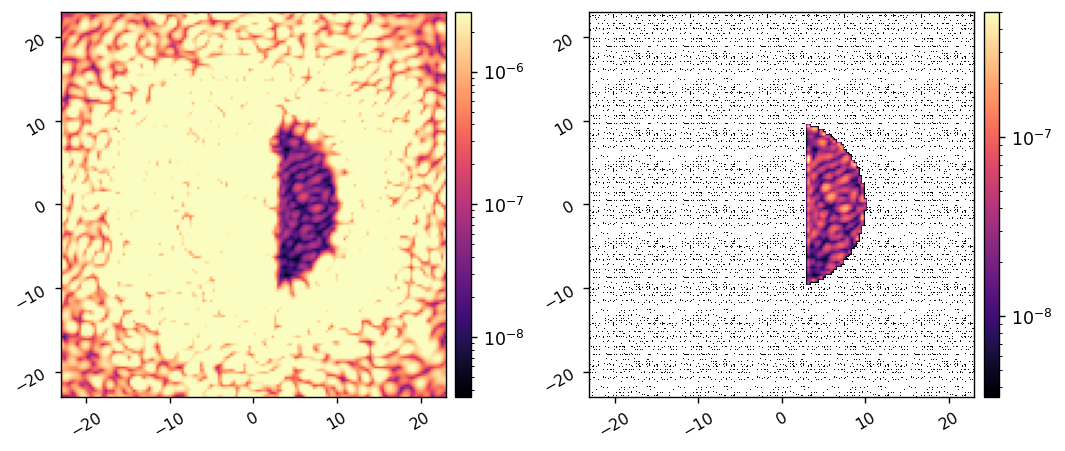

In [268]:
I.Nframes = 10
I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()

print(xp.mean(coro_im[new_control_mask]))
imshow2(coro_im, new_control_mask * coro_im,
        lognorm=True, pxscl=I.psf_pixelscale_lamD)

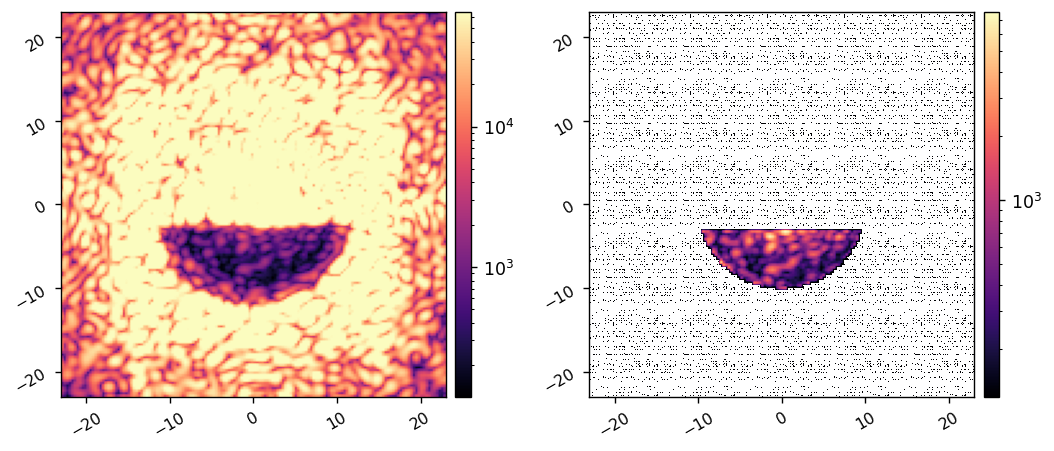

In [196]:
I.Nframes = 10
I.subtract_dark = False
I.return_ni = False

raw_coro_im = I.snap()

imshow2(raw_coro_im, new_control_mask * raw_coro_im,
        lognorm=True, pxscl=I.psf_pixelscale_lamD)

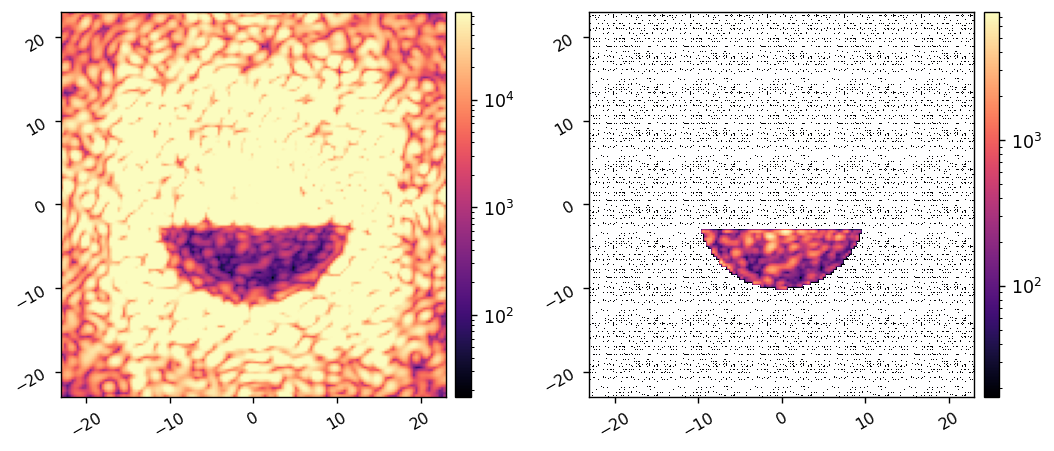

In [197]:
imshow2(raw_coro_im - dark_frame, new_control_mask * (raw_coro_im - dark_frame),
        lognorm=True, pxscl=I.psf_pixelscale_lamD)

In [277]:
I.zero_dm( )
I.set_zwo_exp_time(0.001, client0)

Set the ZWO exposure time to 1.00e-03s


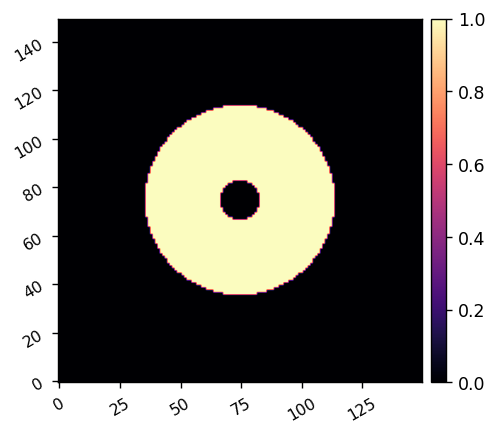

In [74]:
new_iwa = 2.5
new_owa = 12
annular_control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, new_iwa, new_owa)
imshow1(annular_control_mask)

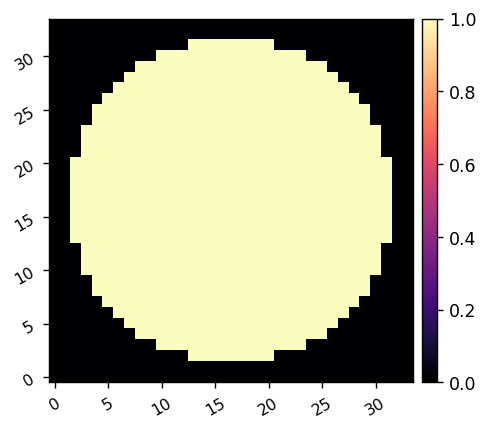

In [94]:
imshow1(I.dm_pupil_mask)

In [98]:
type(I.dm_pupil_mask), type(response_mask)

(numpy.ndarray, cupy.ndarray)

727


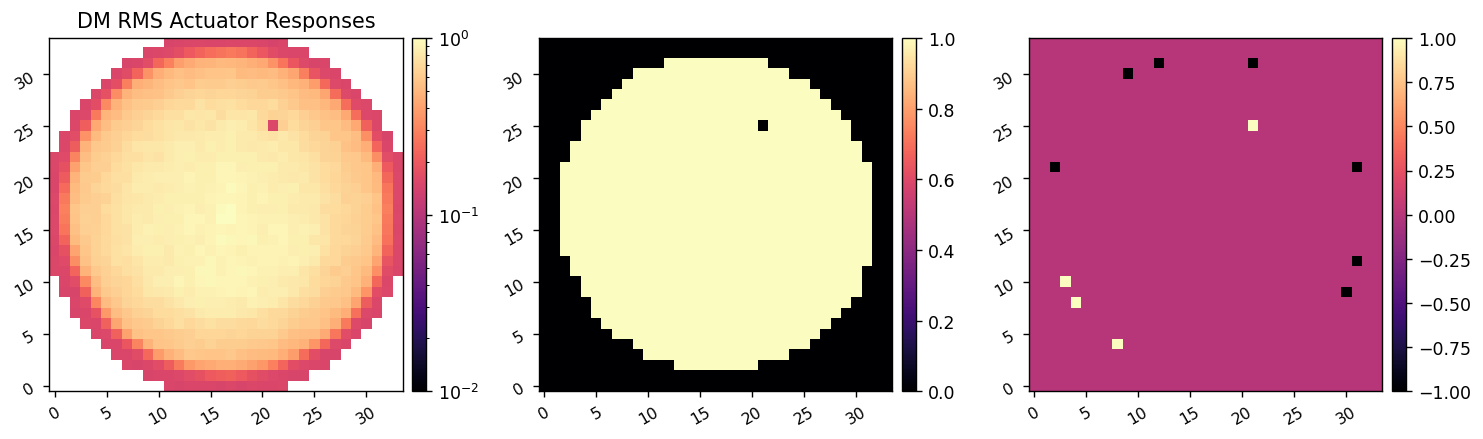

In [104]:
annular_response_matrix = response_cube[:, :, annular_control_mask.ravel()].reshape(1024, -1).T
full_response_map = xp.sqrt(xp.mean(xp.square(annular_response_matrix.dot(calib_modes)), axis=0))
full_response_map = full_response_map.reshape(I.Nact, I.Nact) / xp.max(full_response_map)
response_mask = full_response_map>3.5e-1
print(response_mask.sum())
imshow3(full_response_map, response_mask, I.dm_pupil_mask.astype(float) - ensure_np_array(response_mask), 
        'DM RMS Actuator Responses', lognorm1=True, vmin1=1e-2)

In [99]:
restart_clients()

INFO:purepyindi2.transports:Connected to localhost:7624


# Monitor the dark hole

Mean NI = 9.39e-08


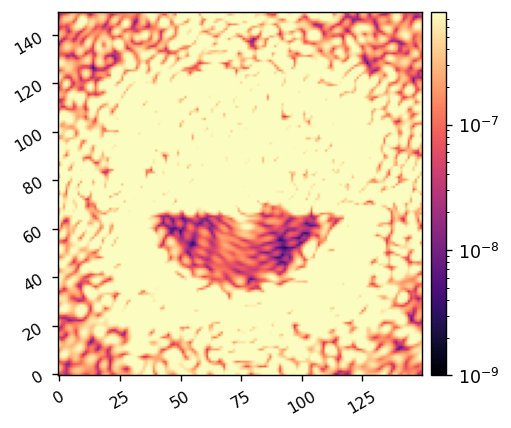

In [101]:
reload(scoobi)
from pathlib import Path

duration = 3600
duration = 2620
I.Nframes = 10

time.sleep(5)
scoobi.stream_scicam(I, 
                     duration=duration, 
                     control_mask=new_control_mask, 
                     plot=True, 
                     clear=True, 
                     save_data_to=Path(f'../camsci-streams/{today}_ims_with_llowfsc.fits'),
                     )

In [163]:
type(I.snap())

cupy.ndarray